# CMI Code for Meshing and Clipping Subduction Zone

### Model inputs

In [9]:
### SET MODEL CHOICES ###

# set depth of CMI
cmi_depth = 40

# set depth of clipping plane for subduction zone
# if coldNose = true, plane_depth!=cmi_depth
plane_depth = 40

# minimum longitude and latitude for the cmi
min_lon = 125 # (originally 137) (wide = 130)
min_lat = 34

# set spatially variable smoothing values to true or false (false=uniform smoothing values)
spatially_var = False

# set smoothing weight for fault and cmi
smooths = [1e-12, 1e-6, 1e2, 1e10, 1e14, 4e14, 1, 1e4] # example vals
fault_smooth = 1e14
cmi_smooth = 1e14 # the smoothing value e.g., 1e14

# save figures automatically to a file, must update test/file name otherwise past testing overwritten
# file will be created and written to a folder named cmiModeling on desktop
saveFigures = False
saveData = False # saves numerical output (e.g., max fault slip mag) as a text file in the outputs directory for the test
testName = "40km_F1e14_C1e14"

# FIGURES #
# choose which figures to save

slip_dist = True # slip distributions plotted on cmi and on fault
disp_sep = True  # map view gps displacements separated into contributions from fault and cmi
all_disp = False # predicted and total displacements map view
cross_fig = False # cross section figure
ratio_fig = True # ratio of cmi contribution to total displacement
resid_fig = True # residual plotting

#### Libraries and necessary functions

In [10]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np # Numerical analysis
import gmsh # Creation of fault models
import meshio # Interaction between fault model files and Python
import matplotlib.pyplot as plt # Visualize 
from pyproj import Proj
import pyproj
from geopandas import geoseries
import os
from expandMesh import expandMesh
from prepareMeshes import findContour
from createMatrices import findEdgeElem, constraintMatrix, createDispSmoothMats

%matplotlib widget

### Read in subduction zone mesh and parse before using it to create a depth contour 

#### Define points along the depth contour given a plane depth by calculating which triangles span the contour, and a point along the two triangle legs that sits at that defined depth.

In [3]:
# Read in source fault

filename = "japan.msh"
mesh = dict()
meshobj = meshio.read(filename)
mesh["file_name"] = filename
mesh["points"] = meshobj.points
mesh["verts"] = meshio.CellBlock("triangle", meshobj.get_cells_type("triangle")).data
ntri = len(mesh["verts"])

mesh = expandMesh(mesh) # expand coordinates and calculate properties of mesh


# Create depth contour points using triangle elements spanning the CMI depth
# fault mesh automatically clipped to match

depth_contour, fault = findContour(mesh, plane_depth)
fault = expandMesh(fault) 

# using pandas not numpy, because numpy will sort the columns, but that shuffles lon, lat pairs apart
if 0:
    plt.close('all')
    fig, ax = plt.subplots()
    plt.scatter(depth_contour[:,0], depth_contour[:,1])
    plt.show()

## Mesh CMI and clip the fault mesh to match

In [4]:
# Mesh the CMI based upon lower depth extent of afterslip

#sort points by increasing latitude
indicies = np.argsort( depth_contour[:,1] )
depth_contour = depth_contour[indicies]

# separately add on the corners of the CMI
# min lon and min lat defined at top
max_lat = np.max(depth_contour[:,1]+2) # maximum latitude for corner

# corner points starting from lower left and moving counterclockwise
corner_points = np.array([[min_lon, min_lat, plane_depth], [depth_contour[0,0], min_lat, plane_depth], [min_lon, max_lat, plane_depth], [np.max(depth_contour[:,0]), max_lat, plane_depth]])

# total points along the perimiter of the CMI mesh
mesh_edge = np.concatenate((depth_contour, corner_points))

# fig, ax = plt.subplots()
# ax.scatter(mesh_edge[:, 0], mesh_edge[:, 1])
# plt.show()

cx = mesh_edge[:,0]
cy = mesh_edge[:,1]
cz = -1*mesh_edge[:,2] # depth is negative

## BEGIN GMSH

char_len = 0.75 # smaller is good for degrees
n_points = np.shape(depth_contour)[0] # number of depth contour points
num_surf = np.shape(depth_contour)[0]
num_lines = np.shape(mesh_edge)[0] #num lines is the same as the total number of points

if gmsh.isInitialized() == 0:
    gmsh.initialize()
gmsh.option.setNumber("General.Verbosity", 0)
gmsh.clear()

# Define points
gmsh.model.geo.addPoint(cx[-4], cy[-4], cz[-4], char_len, 0) #lower left corner because corner points were added last in the mesh_points
gmsh.model.geo.addPoint(cx[-3], cy[-3], cz[-3], char_len, 1)
for j in range(int(n_points)): # depth contour points
    gmsh.model.geo.addPoint(cx[j], cy[j], cz[j], char_len, j+2) 

gmsh.model.geo.addPoint(cx[-1], cy[-1], cz[-1], char_len, j+3) #upper right corner
gmsh.model.geo.addPoint(cx[-2], cy[-2], cz[-2], char_len, j+4) #upper left corner

# add lines between the points to complete the perimiter
for i in range(int(num_lines-1)):
    gmsh.model.geo.addLine(i, i+1, i)
gmsh.model.geo.addLine(i+1, 0, i+1) #complete the loop

gmsh.model.geo.synchronize()

# define curve loop counterclockwise
gmsh.model.geo.addCurveLoop(list(range(0, i+2)), 1)

gmsh.model.geo.addPlaneSurface([1], 1)

# Finish writing geo attributes
gmsh.model.geo.synchronize()

gmsh.write('horiz' + '.geo_unrolled')

# Generate mesh
gmsh.model.mesh.generate(2) #meshed in spherical because the depth being in km isn't as important when it's flat

gmsh.write('horiz' + '.msh')
gmsh.finalize()  

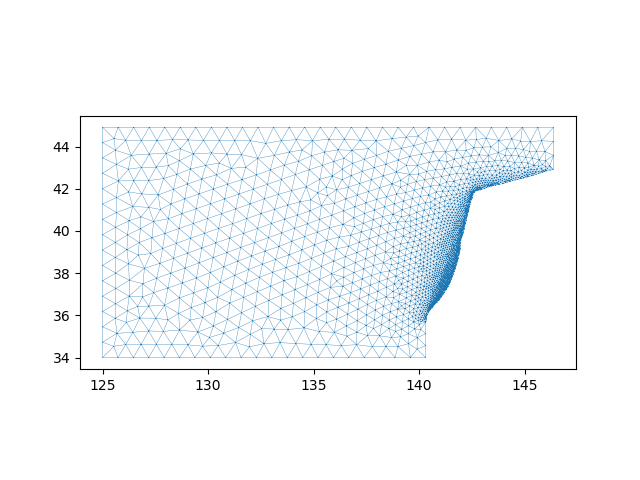

In [5]:
# expand the CMI mesh
horiz = dict()

# information about the CMI mesh is read in, and stored in a dictionary just like for fault mesh earlier
horizobj = meshio.read("horiz.msh") 
horiz["points"] = horizobj.points
horiz["verts"] = meshio.CellBlock("triangle", horizobj.get_cells_type("triangle")).data

keep_el = np.ones(len(horiz["verts"])).astype(bool)

for i in range(len(horiz["verts"])):
    tri_test = np.shape(np.unique(horiz["points"][horiz["verts"][i,:],:],axis=0))[0]
    if tri_test != 3:
        keep_el[i] = False

horiz["verts"] = horiz["verts"][keep_el,:]

horiz = expandMesh(horiz) # expand mesh coordinates


# Draw the cmi 
plt.close('all')
fig, ax = plt.subplots()
ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()

#### Clip fault mesh, then remesh to fix triangle shapes

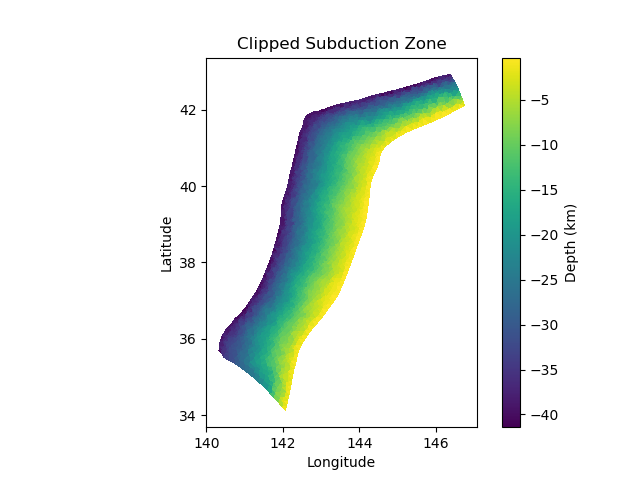

In [6]:

# #Show elements colored by depth
if 1:
    plt.close('all')
    fig, ax = plt.subplots()
    fo = ax.tripcolor(fault["points"][:, 0], fault["points"][:, 1], fault["verts"], facecolors=fault["centroids"][:,2])
    plt.colorbar(fo, label="Depth (km)") #uses info from plotted object to create scale
    ax.title.set_text("Clipped Subduction Zone")
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    ax.set(aspect='equal')
    plt.show()


### Cold nose model

In [ ]:
## create "cold nose" kink for cmi SET TO FALSE FOR NOW
if 0:
    import scipy.spatial.distance as scipy

    # change the depth values in depth contour to be negative instead of positive convention
    group2 = np.zeros_like(depth_contour)
    group2[:,0] = depth_contour[:,0]
    group2[:,1] = depth_contour[:,1]
    group2[:,2] = -1*depth_contour[:,2]

    group1 = horiz["points"]

    # contains the distances between all combinations of points
    # the minimum distance per row (per cmi point) is what is important
    distance_matrix = scipy.cdist(group1, group2, "euclidean")

    # units are degrees of latitude and longitude
    # does this create any problems?
    min_dist = distance_matrix.min(axis=1) # axis = 1 for each row
    min_dist = 111 * min_dist # estimate to km (?)

    cold_distance = 50 # how far away the cold nose is
    steps = np.linspace(0, cold_distance, 5)
    # bool mask for greater than 50 km
    step1 = min_dist >= steps[-1]

    # temporarily change those distances to -1 so that further sorting doesn't access them
    temp = min_dist
    temp[step1] = -1

    # boolean mask for between 40 and 50 km
    step2 = temp > steps[-2]

    temp2 = temp
    temp2[step2] = -1

    # boolean mask for between 30 and 40 km
    step3 = temp2 > steps[-3]

    temp3 = temp2
    temp3[step3] = -1

    # boolean mask for between 20 and 30 km
    step4 = temp3 > steps[-4]

    temp4 = temp3
    temp4[step4] = -1

    # boolean mask for between 10 and 20 km
    step5 = temp4 >= steps[-5]

    # temp5 = temp4
    # temp5[step5] = -1

    # # boolean mask for between 0 and 10 km (including zero)
    # step6 = (temp5 >= 0)

    ### use the boolean masks created above to sort out the different steps creating the cold nose
    ### and once they're sorted, access the depth element of the points and change it to the correct step

    cmi_pts_depth = horiz["points"][:,2]

    cold_depths = np.linspace(-cmi_depth, -plane_depth, np.size(steps))

    # step 1
    cmi_pts_depth[step1] = cold_depths[0]
    # step 2
    cmi_pts_depth[step2] = cold_depths[1]
    # step 3
    cmi_pts_depth[step3] = cold_depths[2]
    # step 4
    cmi_pts_depth[step4] = cold_depths[3]
    # step 5
    cmi_pts_depth[step5] = cold_depths[4]

    horiz["points"][:,2] = cmi_pts_depth

    ### REDO MESH EXPANSION ###

    horiz = expandMesh(horiz) # REDO MESH EXPANSION # 


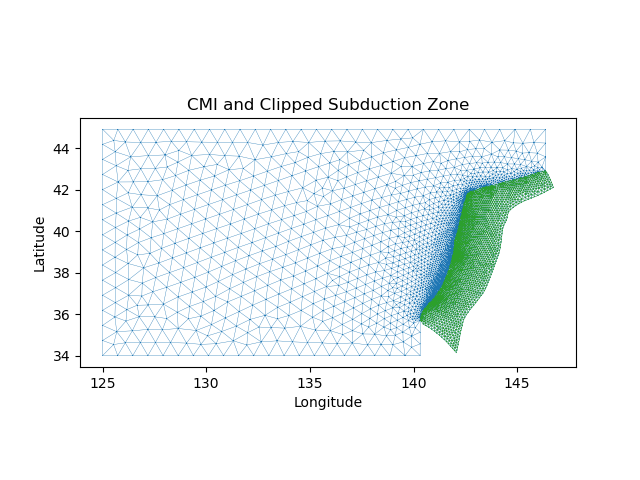

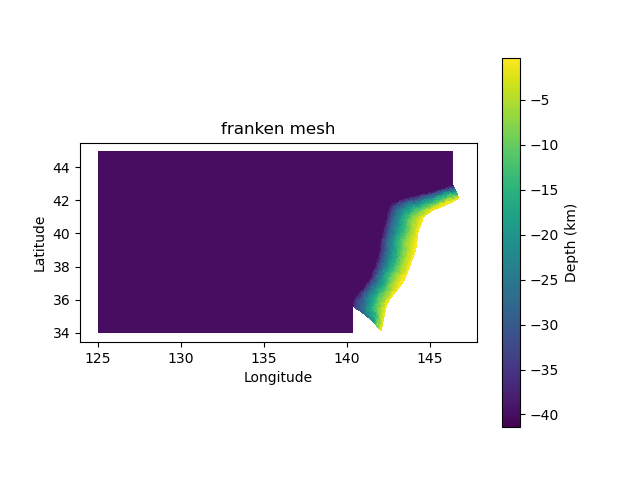

In [7]:
# franken mesh sticking the CMI and Fault together
both = {}
both["points"] = np.vstack((fault["points"], horiz["points"]))
shift_val = len(fault["points"][:,0])
both["verts"] = np.vstack((fault["verts"], horiz["verts"]+shift_val))
both["centroids"] = np.vstack((fault["centroids"], horiz["centroids"]))
both["lon1"] = np.vstack((fault["lon1"].reshape(-1,1), horiz["lon1"].reshape(-1,1))).flatten()
both["lon2"] = np.vstack((fault["lon2"].reshape(-1,1), horiz["lon2"].reshape(-1,1))).flatten()
both["lon3"] = np.vstack((fault["lon3"].reshape(-1,1), horiz["lon3"].reshape(-1,1))).flatten()
both["lat1"] = np.vstack((fault["lat1"].reshape(-1,1), horiz["lat1"].reshape(-1,1))).flatten()
both["lat2"] = np.vstack((fault["lat2"].reshape(-1,1), horiz["lat2"].reshape(-1,1))).flatten()
both["lat3"] = np.vstack((fault["lat3"].reshape(-1,1), horiz["lat3"].reshape(-1,1))).flatten()
both["dep1"] = np.vstack((fault["dep1"].reshape(-1,1), horiz["dep1"].reshape(-1,1))).flatten()
both["dep2"] = np.vstack((fault["dep2"].reshape(-1,1), horiz["dep2"].reshape(-1,1))).flatten()
both["dep3"] = np.vstack((fault["dep3"].reshape(-1,1), horiz["dep3"].reshape(-1,1))).flatten()

both["x1"] = np.vstack((fault["x1"].reshape(-1,1), horiz["x1"].reshape(-1,1))).flatten()
both["y1"] = np.vstack((fault["y1"].reshape(-1,1), horiz["y1"].reshape(-1,1))).flatten()
both["z1"] = np.vstack((fault["z1"].reshape(-1,1), horiz["z1"].reshape(-1,1))).flatten()
both["x2"] = np.vstack((fault["x2"].reshape(-1,1), horiz["x2"].reshape(-1,1))).flatten()
both["y2"] = np.vstack((fault["y2"].reshape(-1,1), horiz["y2"].reshape(-1,1))).flatten()
both["z2"] = np.vstack((fault["z2"].reshape(-1,1), horiz["z2"].reshape(-1,1))).flatten()
both["x3"] = np.vstack((fault["x3"].reshape(-1,1), horiz["x3"].reshape(-1,1))).flatten()
both["y3"] = np.vstack((fault["y3"].reshape(-1,1), horiz["y3"].reshape(-1,1))).flatten()
both["z3"] = np.vstack((fault["z3"].reshape(-1,1), horiz["z3"].reshape(-1,1))).flatten()

both["x_centroid"] = np.vstack((fault["x_centroid"].reshape(-1,1), horiz["x_centroid"].reshape(-1,1))).flatten()
both["y_centroid"] = np.vstack((fault["y_centroid"].reshape(-1,1), horiz["y_centroid"].reshape(-1,1))).flatten()
both["z_centroid"] = np.vstack((fault["z_centroid"].reshape(-1,1), horiz["z_centroid"].reshape(-1,1))).flatten()

both["nv"] = np.vstack((fault["nv"], horiz["nv"]))
both["strike"] = np.vstack((fault["strike"].reshape(-1,1), horiz["strike"].reshape(-1,1))).flatten()
both["dip"] = np.vstack((fault["dip"].reshape(-1,1), horiz["dip"].reshape(-1,1))).flatten()
both["dip_flag"] = np.vstack((fault["dip_flag"].reshape(-1,1), horiz["dip_flag"].reshape(-1,1))).flatten()


plt.close('all')
fig, ax = plt.subplots()
ax.triplot(both["points"][:, 0], both["points"][:, 1], both["verts"], linewidth=0.25)
ax.triplot(fault["points"][:,0], fault["points"][:,1], fault["verts"], linewidth=0.25)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("CMI and Clipped Subduction Zone")
ax.set_aspect("equal")
plt.show()

# #Show elements colored by depth
if 1:
    plt.close('all')
    fig, ax = plt.subplots()
    fo = ax.tripcolor(both["points"][:, 0], both["points"][:, 1], both["verts"], facecolors=both["centroids"][:,2])
    plt.colorbar(fo, label="Depth (km)") #uses info from plotted object to create scale
    ax.title.set_text("franken mesh")
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    ax.set(aspect='equal')
    plt.show()


## Inversion Code

#### Read in GPS data

In [8]:
colnames = ["station_ID", 'lon', 'lat', 'east_vel', 'north_vel', 'up_vel']
gps = pd.read_table("./cumulative_disp.txt", sep='\s+', header=None, names=colnames)

# Place stations into single array
# lat, lon, dep, but dep is always zero because they're on the ground
# reshape(3, -1) means put it into 3 rows and as many columns as data points
# then T makes it 3 columns, and as many rows as data points
obsv = np.array([gps.lon, gps.lat, 0*gps.lat]).reshape((3, -1)).T.copy()

vec_scale = 2000

plot_vectors = False
plt.close('all')
if plot_vectors:
    coast = pd.read_csv("coastline.csv")
    lon_corr = 1
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(coast.lon+360*(1-lon_corr), coast.lat, color="k", linewidth=0.5)
    ax[0].quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale)
    ax[0].set_xlim([129, 147])
    ax[0].set_ylim([27, 48])
    ax[1].quiver(gps.lon, gps.lat, 0, gps.up_vel, scale=vec_scale/10)
    ax[1].axis("equal")
    plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7c/8db84z1953v2yvj0hb957l_h0000gp/T/ipykernel_25626/3246895490.py:2: SyntaxWarning: invalid escape sequence '\s'
  gps = pd.read_table("./cumulative_disp.txt", sep='\s+', header=None, names=colnames)


### Concatenate Meshes and calculate partial derivatives

In [ ]:
import celeri 

# Force meshes into dataclass, using existing fields
class Mesh:
    def __init__(self, d=None):
        if d is not None:
            for key, value in d.items():
                setattr(self, key, value)

# List of classes
meshes = [Mesh(fault), Mesh(horiz)]


# Define indices for meshes in arrays, where each meshes triangle elements begin
n_tri = np.zeros(len(meshes), dtype=int)
for i in range(len(meshes)):
    n_tri[i] = len(meshes[i].lon1)
tri_end_idx = np.cumsum(n_tri) # the last triangle index, the sum of all triangle elem in both meshes
tri_beg_idx = [0, tri_end_idx[0]] # list of indexes, the beginning of the fault mesh elem, beginning of the cmi mesh elem
total_n_tri = tri_end_idx[-1] 
# gets the last element of the summation that makes up total triangles, here, the number of tri elem in the CMI

# function automatically removes tensile rows and columns from the subduction zone matrix in disp mat
# and it then removes teh corresponding rows and columns of smoothing mat, leaving it as a square matrix
disp_mat, smoothing_mat = createDispSmoothMats(gps, np.sum(n_tri), tri_beg_idx, tri_end_idx, meshes)


Calculating cutde partials for triangles: 100%|██████████| 3702/3702 [00:04<00:00, 914.66it/s]


##### Mini test to check for flattened elements

In [15]:
# test if elem are line elem instead of triangle , if there is an error, that is GOOD
if 0:
    bad_cols = np.isnan(disp_mat[0,:])
    bad_el = int(np.where(bad_cols)[0][0]/3)

    thing = bad_el - tri_beg_idx[1]
    print(np.shape(np.unique(horiz["points"][horiz["verts"][thing,:],:],axis=0))[0])
    print(horiz["verts"][thing,:])

    # Draw the fault 
    fig, ax = plt.subplots()
    ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
    ax.plot(horiz["centroids"][thing,0], horiz["centroids"][thing,1], "*r")
    ax.set_aspect("equal")
    plt.show()

In [9]:
# find elements on the minimum longitude and maximum latitude edge of the CMI

horiz = findEdgeElem(horiz)


#### Assemble matrices, constraints, weighting vector, and data vector

In [ ]:
# create constraint matrices

# find edge elem to constrain slip, the meshes are too large
# they're currently set up to constrain the dip slip
celeri.mesh._compute_mesh_edge_elements(fault) 

# find elements above 20 km depth on fault for constraint matrix
too_high = np.where(fault["centroids"][:,2]>-20)[0]

# allocate space for constraint arrays 

# fault constraints
top_elem = sum(fault["top_elements"]) 
top_elem2 = len(too_high) - top_elem 
side_elem = sum(fault["side_elements"]) 

topConstraint = np.zeros(((2*(top_elem)), len(disp_mat[0])))       # top edge elements
topConstraint2 = np.zeros(((2*(top_elem2)), len(disp_mat[0])))     # top 20 km (not including top edge elements)
sideConstraint = np.zeros(((2*(side_elem)), len(disp_mat[0])))     # along the sides of the subduction zone

# find the set difference 
too_high = np.setdiff1d(top_elem, too_high) # so that the top edge elements aren't in both constraint arrays for upper elements

# locations of top and side elements in the fault mesh
idx = np.nonzero(fault["top_elements"])[0].reshape(-1,1)    # returns a row index for each nonzero (true) val
idx2 = np.nonzero(fault["side_elements"])[0].reshape(-1,1)

# add ones in the constraint matrices for where slip is to be minimized/not allowed

# top edge elements
topConstraint = constraintMatrix(idx, topConstraint, False)

# elements above 20 km depth
topConstraint2 = constraintMatrix(too_high, topConstraint2, False)

# elements along the sides of the fault
sideConstraint = constraintMatrix(idx2, sideConstraint, False)


# CMI constraint matrix containing elements on the top and left edge of the plane
edge_elem = sum(horiz["far_north"]) + sum(horiz["far_west"])
horizConstraint = np.zeros(((3*edge_elem), len(disp_mat[0])))

west_idx = np.nonzero(horiz["far_west"])[0].reshape(-1,1) # gives the row number of elements that touch the min lon value
north_idx = np.nonzero(horiz["far_north"])[0].reshape(-1,1)
horiz_rows = np.vstack((west_idx, north_idx)) # compiled rows of north/west elem

# CMI element indicies need to be shifted by the number of fault elements
shift = 2*len(fault["lon1"]) # two not three because tensile col has already been removed from fault elements

horizConstraint = constraintMatrix(horiz_rows, horizConstraint, True, shift=shift)

# modify indexing lists to account for the new elements in constraint arrays
# this is important for later when the weights are saved in an array

# shift for fault top elements 
tri_beg_idx.append(tri_end_idx[len(meshes)-1])
tri_end_idx = np.append(tri_end_idx, [tri_end_idx[len(meshes)-1]+len(topConstraint[0:,])], axis=0)

# shift for upper fault elements 
tri_beg_idx.append(tri_end_idx[len(meshes)])
tri_end_idx = np.append(tri_end_idx, [tri_end_idx[len(meshes)]+len(topConstraint2[0:,])], axis=0)

# shift for fault side elements
tri_beg_idx.append(tri_end_idx[len(meshes)+1])
tri_end_idx = np.append(tri_end_idx, [tri_end_idx[len(meshes)+1]+len(sideConstraint[0:,])], axis=0)

# shift for cmi edge elements
tri_beg_idx.append(tri_end_idx[len(meshes)+2])
tri_end_idx = np.append(tri_end_idx, [tri_end_idx[len(meshes)+2]+len(horizConstraint[0:,])], axis=0)


In [ ]:
# create a spatially variable smoothing weight based upon the resolution of the triangles

### option 1 ###
closeness = np.abs(disp_mat.sum(axis=0))# sum is column wise

# then its the sum of all the stations for each triangle ss, ds, and ts (if even) 


In [ ]:
# Assemble matrices 

# assembled_mat = np.vstack([disp_mat, smoothing_mat, fault_constraint, horiz_constraint]) # stick constraint array as 3rd argument
assembled_mat = np.vstack([disp_mat, smoothing_mat, topConstraint, topConstraint2, sideConstraint, horizConstraint]) # stick constraint array as 3rd argument


# create new indexing lists to accommodate the differences between 2*fault_elem and 3*cmi elem after removing tensile slip
fault_end = tri_end_idx[0]*2
horiz_end = fault_end + len(horiz["lon1"])*3

top_constraint_end = horiz_end + len(topConstraint[0:,])
top_constraint2_end = top_constraint_end + len(topConstraint2[0:,])
side_constraint_end = top_constraint2_end + len(sideConstraint[0:,])

all_elem_beg = [0, fault_end, horiz_end, top_constraint_end, top_constraint2_end, side_constraint_end]
all_elem_end = [all_elem_beg[1], all_elem_beg[2], all_elem_beg[3], all_elem_beg[4], all_elem_beg[5], all_elem_beg[5]+len(horizConstraint[0:,])]


# set smoothing and constraint weights
# NOTE: smoothing weights set as model inputs at top

if spatially_var:
    fault_smoothing = (fault_smooth* np.reciprocal(closeness[0:all_elem_beg[1]])).reshape(-1, 1) # into column vector so it fits in weights
    cmi_smoothing = (fault_smooth* np.reciprocal(closeness[all_elem_beg[1]:])).reshape(-1,1)
else: 
    fault_smoothing = fault_smooth
    cmi_smoothing = cmi_smooth

top_weight = 1e4
upper_weight = 1
side_weight = 1
cmi_side_weight = 1e2

smoothing_weight = [fault_smoothing, cmi_smoothing, top_weight, upper_weight, side_weight, cmi_side_weight] 
if len(smoothing_weight) != (len(meshes)+4): # 2 meshes, and 4 constraint arrays need to all be weighted
    smoothing_weight = smoothing_weight*np.ones(len(meshes)) 

# Assemble weighting vector
# Allocate space for data vector
data_vector = np.zeros((np.shape(assembled_mat)[0], 1)) # by default, the rows corresponding to constraint array are initialized as zeros
# Vector of displacements
disp_array = np.array([gps.east_vel, gps.north_vel, gps.up_vel]).reshape((3,-1)).T.copy()
data_vector[0:np.size(disp_array)] = disp_array.flatten().reshape(-1,1)


# Start with unit uncertainties 
# this puts the smoothing weight for the fault mesh and cmi mesh, and leaves gps stations as 1
weights = np.ones((np.shape(assembled_mat)[0], 1)) # might want to update when adding slip constraint

for mesh_idx in range(len(meshes)+4):
    weights[np.size(disp_array)+ all_elem_beg[mesh_idx]:np.size(disp_array)+all_elem_end[mesh_idx]] = smoothing_weight[mesh_idx]



### Bulk testing with nested loop

In [20]:
## CURRENTLY DISABLED
# nested loop to test the different effects of different combos of smoothing weights on fault and cmi
if 0:
    smooths = [1e12, 1e13, 1e14, 1e15]

    max_fault_slip = np.empty((len(smooths)**2, 2))
    max_horiz_slip = np.empty((len(smooths)**2, 2))
    m = 0 # counter
    mean_residuals = np.empty((len(smooths)**2, 3))

    for i in range(len(smooths)):
        for j in range(len(smooths)):
            smoothing_weight = [smooths[i], smooths[j], 1e-12, 1e-4, 1e2] 
            data_vector = np.zeros((np.shape(assembled_mat)[0], 1))
            disp_array = np.array([gps.east_vel, gps.north_vel, gps.up_vel]).reshape(3,-1).T.copy()
            data_vector[0:np.size(disp_array)] = disp_array.flatten().reshape(-1,1)

            weights = np.ones((np.shape(assembled_mat)[0], 1)) 
            for mesh_idx in range(len(meshes)+3):
                weights[np.size(disp_array)+ all_elem_beg[mesh_idx]:np.size(disp_array)+all_elem_end[mesh_idx]] = smoothing_weight[mesh_idx]

            
            # perform inversion
            # Calculate model covariance
            cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

            # Estimate slip using pre-calculated covariance
            est_slip = cov @ assembled_mat.T * weights.T @ data_vector 
            # Predict displacement at stations
            pred_disp = disp_mat.dot(est_slip) 

            # save val for max slip mag on sub and max slip mag on cmi and corresponding smoothing val
            # dip slip on the CMI represents east-west motion, where east is negative and west is positive
            slip_type = 1 # 0 = strike slip 1 = dip slip
            end_idx = 2*tri_end_idx[0] #end of fault elem beginning of cmi elem
            slip_vals = [est_slip[slip_type:end_idx:2]/100, est_slip[slip_type+ end_idx::3]/100] # dip slip values for fault and CMI, converted from cm to m

            max_fault_slip[m, 0] = np.abs(np.max(slip_vals[0]))
            max_fault_slip[m, 1] = smooths[i] # smoothing weight on the subduction zone
            max_horiz_slip[m, 0] = np.abs(np.max(slip_vals[1]))
            max_horiz_slip[m, 1] = smooths[j] # smoothing weight on CMI
            
            # save val for mean residual displacements and corresponding smoothing vals for fault and cmi

            residuals = np.empty((len(gps.lon), 3))
            actual = np.hstack((np.array(gps.east_vel).reshape(-1,1), np.array(gps.north_vel).reshape(-1,1), np.array(gps.up_vel).reshape(-1,1)))

            calc_east = pred_disp[0::3].flatten()
            calc_north = pred_disp[1::3].flatten()
            calc_up = pred_disp[2::3].flatten()

            residuals[:,0] = actual[:,0] - calc_east
            residuals[:,1] = actual[:,1] - calc_north
            residuals[:,2] = actual[:,2] - calc_up

            mean_residuals[m, 0] = np.mean(residuals)
            mean_residuals[m, 1] = smooths[i] # fault
            mean_residuals[m, 2] = smooths[j] # cmi
            m+=1
            print(i,j)



### Plotting

In [21]:
# CURRENTLY DISABLED
# plot for visualizing
if 0:
    smooth_combos = np.empty_like(max_horiz_slip)
    smooth_combos[:,0] = max_fault_slip[:,1]
    smooth_combos[:,1] = max_horiz_slip[:,1]

    # combo for minimum fault slip
    min_fault_slip = np.min(max_fault_slip)
    loc = np.argwhere(max_fault_slip[:,0]==min_fault_slip)[0]
    print("Minimum fault slip (m): ", min_fault_slip)
    print("Minimum fault slip in the combo [Fault, CMI]: ", smooth_combos[loc])
    print()

    # combo for minimum cmi slip
    min_cmi_slip = np.min(max_horiz_slip)
    loc2 = np.argwhere(max_horiz_slip[:,0]==min_cmi_slip)[0]
    print("Minimum CMI slip (m): ", min_cmi_slip)
    print("Minimum CMI slip at the combo [Fault, CMI]: ", smooth_combos[loc2])
    print()

    # combo for minimum average slip
    total_slip = np.vstack((max_fault_slip[:,0], max_horiz_slip[:,0]))
    avg_max_slip = ((max_horiz_slip[:,0] + max_fault_slip[:,0])/2).reshape(-1,1) 
    min_slip = np.min(avg_max_slip)
    least_slip = np.argwhere(avg_max_slip[:,0]==min_slip)[0]
    print("Minimum average slip at the combo [Fault, CMI]: ", smooth_combos[least_slip])
    print()

    # combo for minimum residuals
    min_residuals = np.min(abs(mean_residuals))
    loc3 = np.argwhere(np.abs(mean_residuals[:,0])==min_residuals)[0]
    print("Minimum (abs val) mean residuals: ", min_residuals)
    print("Minimum mean residuals at the combo [Fault, CMI]: ", smooth_combos[loc3])
    print()

    #sort the horiz slip array for easier total plotting
    sorted_idx = max_horiz_slip[:,1].argsort()
    max_horiz_slip_srtd = max_horiz_slip[sorted_idx]

    plt.close('all')
    plt.semilogx(max_fault_slip[:,1], max_fault_slip[:,0], color = "green", label="Fault Slip")
    plt.semilogx(max_fault_slip[:,1], max_horiz_slip_srtd[:,0], color='b', label="CMI slip")
    plt.xlabel("Slip weight")
    plt.ylabel("Maximum slip mag (m)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
# CURRENTLY DISABLED
# COMBO 1
# fault slip (12, 12, 12, 12) cmi (12, 13, 14, 15)
# code from https://matplotlib.org/stable/gallery/axisartist/demo_parasite_axes2.html#sphx-glr-gallery-axisartist-demo-parasite-axes2-py 
if 0:
    from mpl_toolkits import axisartist
    from mpl_toolkits.axes_grid1 import host_subplot
    total_slip1 = np.vstack((max_fault_slip[0:4, 0], max_horiz_slip[0:4, 0]))
    plt.close('all')
    host = host_subplot(111, axes_class=axisartist.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(50, 0))
    par1.axis["right"].toggle(all=True)
    par2.axis["right"].toggle(all=True)

    p1, = host.plot(smooth_combos[0:4, 1], max_fault_slip[0:4, 0], color='b', label="Fault")
    p2, = par1.plot(smooth_combos[0:4, 1], max_horiz_slip[0:4, 0], color='r', label="Horiz")
    p3, = par2.plot(smooth_combos[0:4, 1], mean_residuals[0:4, 0], color='g', label="Residuals")

    host.set_xscale('log')
    host.set(xlabel="CMi Slip weight", ylabel="Fault slip")
    host.set(ylim=[np.min(total_slip1), np.max(total_slip1)])
    par1.set(ylabel="CMI slip", ylim=[np.min(total_slip1), np.max(total_slip1)])
    par2.set(ylabel="Residuals")

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())
    plt.title("Max slip and residuals when Fault slip weight is 1e12")
    plt.show()

In [23]:
# CURRENTLY DISABLED
if 0:
    # COMBO 2
    # fault slip (13, 13, 13, 13) cmi (12, 13, 14, 15)
    from mpl_toolkits import axisartist
    from mpl_toolkits.axes_grid1 import host_subplot
    plt.close('all')
    total_slip2 = np.vstack((max_fault_slip[4:8, 0], max_horiz_slip[4:8, 0]))
    plt.close('all')
    host = host_subplot(111, axes_class=axisartist.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(50, 0))
    par1.axis["right"].toggle(all=True)
    par2.axis["right"].toggle(all=True)

    p1, = host.plot(smooth_combos[4:8, 1], max_fault_slip[4:8, 0], color='b', label="Fault")
    p2, = par1.plot(smooth_combos[4:8, 1], max_horiz_slip[4:8, 0], color='r', label="Horiz")
    p3, = par2.plot(smooth_combos[4:8, 1], mean_residuals[4:8, 0], color='g', label="Residuals")

    host.set_xscale('log')
    host.set(xlabel="CMi Slip weight", ylabel="Fault slip")
    host.set(ylim=[np.min(total_slip2), np.max(total_slip2)])
    par1.set(ylabel="CMI slip", ylim=[np.min(total_slip2), np.max(total_slip2)])
    par2.set(ylabel="Residuals")

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())
    plt.title("Max slip and residuals when Fault slip weight is 1e13")
    plt.show()

In [24]:
# CURRENTLY DISABLED
# COMBO 3
if 0:
    # fault slip (14, 14, 14, 14) cmi (12, 13, 14, 15)
    plt.close('all')
    total_slip3 = np.vstack((max_fault_slip[8:12, 0], max_horiz_slip[8:12, 0]))
    plt.close('all')
    host = host_subplot(111, axes_class=axisartist.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(50, 0))
    par1.axis["right"].toggle(all=True)
    par2.axis["right"].toggle(all=True)

    p1, = host.plot(smooth_combos[8:12, 1], max_fault_slip[8:12, 0], color='b', label="Fault")
    p2, = par1.plot(smooth_combos[8:12, 1], max_horiz_slip[8:12, 0], color='r', label="Horiz")
    p3, = par2.plot(smooth_combos[8:12, 1], mean_residuals[8:12, 0], color='g', label="Residuals")

    host.set_xscale('log')
    host.set(xlabel="CMi Slip weight", ylabel="Fault slip")
    host.set(ylim=[np.min(total_slip3), np.max(total_slip3)])
    par1.set(ylabel="CMI slip", ylim=[np.min(total_slip3), np.max(total_slip3)])
    par2.set(ylabel="Residuals")

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())
    plt.title("Max slip and residuals when Fault slip weight is 1e14")
    plt.show()

In [25]:
    # CURRENTLY DISABLED
# COMBO 4
    # fault slip (15, 15, 15, 15) cmi (12, 13, 14, 15)
if 0:
    plt.close('all')
    total_slip4 = np.vstack((max_fault_slip[12:16, 0], max_horiz_slip[12:16, 0]))
    plt.close('all')
    host = host_subplot(111, axes_class=axisartist.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(50, 0))
    par1.axis["right"].toggle(all=True)
    par2.axis["right"].toggle(all=True)

    p1, = host.plot(smooth_combos[12:16, 1], max_fault_slip[12:16, 0], color='b', label="Fault")
    p2, = par1.plot(smooth_combos[12:16, 1], max_horiz_slip[12:16, 0], color='r', label="Horiz")
    p3, = par2.plot(smooth_combos[12:16, 1], mean_residuals[12:16, 0], color='g', label="Residuals")

    host.set_xscale('log')
    host.set(xlabel="CMi Slip weight", ylabel="Fault slip")
    host.set(ylim=[np.min(total_slip4), np.max(total_slip4)])
    par1.set(ylabel="CMI slip", ylim=[np.min(total_slip4), np.max(total_slip4)])
    par2.set(ylabel="Residuals")

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())
    plt.title("Max slip and residuals when Fault slip weight is 1e15")
    plt.show()

## Perform inversion

In [26]:
# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

# Estimate slip using pre-calculated covariance
est_slip = cov @ assembled_mat.T * weights.T @ data_vector 
# Predict displacement at stations
pred_disp = disp_mat.dot(est_slip) 
# run to check sign convention of dip slip (neg = east pos = west on CMI)
# pred_disp = disp_mat[:, 1+all_elem_beg[1]::3].dot(est_slip[1+all_elem_beg[1]::3])

### plotting of outputs (visual processing)

In [27]:
# creates a folder to save the figures, if saveFigures==True

if saveFigures:
    os.system('mkdir ~/Desktop/cmiModeling/' + testName)
    fig_path = os.path.join("~/Desktop/cmiModeling", testName)

#### Slip distributions

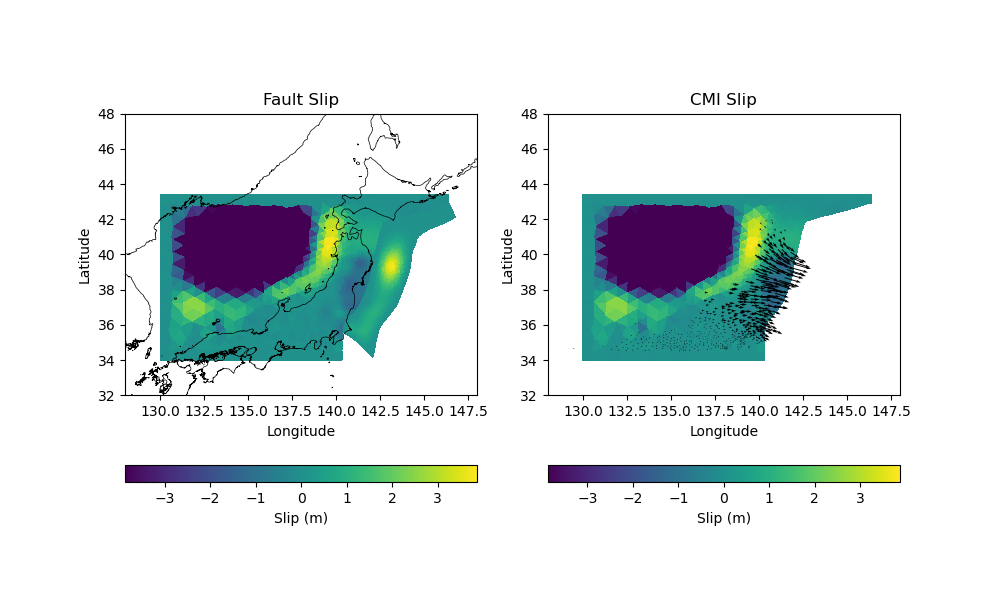

In [28]:
# plot for visualizing
xmin = min_lon
xmax = 148
ymin = 32
ymax = 48
plt.close('all')

coast = pd.read_csv("coastline.csv")
lon_corr = 1
# dip slip on the CMI represents east-west motion, where east is negative and west is positive
slip_type = 1 # 0 = strike slip 1 = dip slip, only for CMI, 2 (manual) is vertical/tensile
end_idx = 2*tri_end_idx[0] #end of fault elem beginning of cmi elem
slip_vals = [est_slip[slip_type:end_idx:2]/100, est_slip[slip_type+end_idx::3]/100] # dip slip values for fault and CMI, converted from cm to m

max_mag_f = np.abs(np.max(slip_vals[0]))
max_mag_h = np.abs(np.max(slip_vals[1]))
if max_mag_f > max_mag_h:
    max_mag = max_mag_f
else:
    max_mag = max_mag_h

total_points = both
fig, ax = plt.subplots(1, 2, figsize=(10,6))
rso = ax[0].tripcolor(both["points"][:,0], 
                      both["points"][:,1], 
                      both["verts"],
                      facecolors=(np.vstack(((slip_vals[0], slip_vals[1])))).flatten(), 
                      vmin=-max_mag, vmax=max_mag)
#ax[0].tripcolor(horiz["points"][:,0], horiz["points"][:,1], horiz["verts"], facecolors=(slip_vals[1]).flatten())
#ax[0].quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r')
cbar1 = fig.colorbar(rso, ax=ax[0], orientation='horizontal')
ax[0].plot(coast.lon+360*(1-lon_corr), coast.lat, color="k", linewidth=0.5)
cbar1.set_label("Slip (m)")
ax[0].set(xlim=(xmin-2, xmax), ylim=(ymin, ymax), aspect='equal')
ax[0].title.set_text("Fault Slip") #graph 1
ax[0].set_ylabel("Latitude")
ax[0].set_xlabel("Longitude")


rso = ax[1].tripcolor(horiz["points"][:,0], horiz["points"][:,1], horiz["verts"], facecolors=(slip_vals[1]).flatten(), vmin=-max_mag_h, vmax=max_mag_h)
cbar1 = fig.colorbar(rso, ax=ax[1], orientation='horizontal')
cbar1.set_label("Slip (m)")
#ax[1].quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r', label="predicted")
ax[1].quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale, color='k', label='observed')
ax[1].set(xlim=(xmin-2, xmax), ylim=(ymin, ymax), aspect='equal')
ax[1].title.set_text("CMI Slip") #graph 1
ax[1].set_ylabel("Latitude")
ax[1].set_xlabel("Longitude")

if saveFigures and slip_dist:
    plt.savefig('slip_dist.png') # save the figure
    os.system('mv ./slip_dist.png ' + fig_path) # move it into the test output folder

plt.show()


#### Displacements by Contribution Origin (fault or cmi)

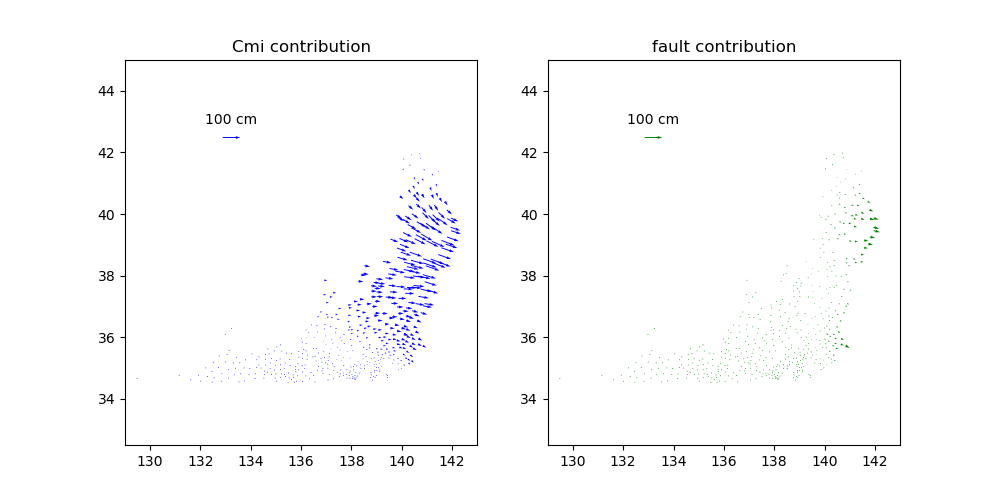

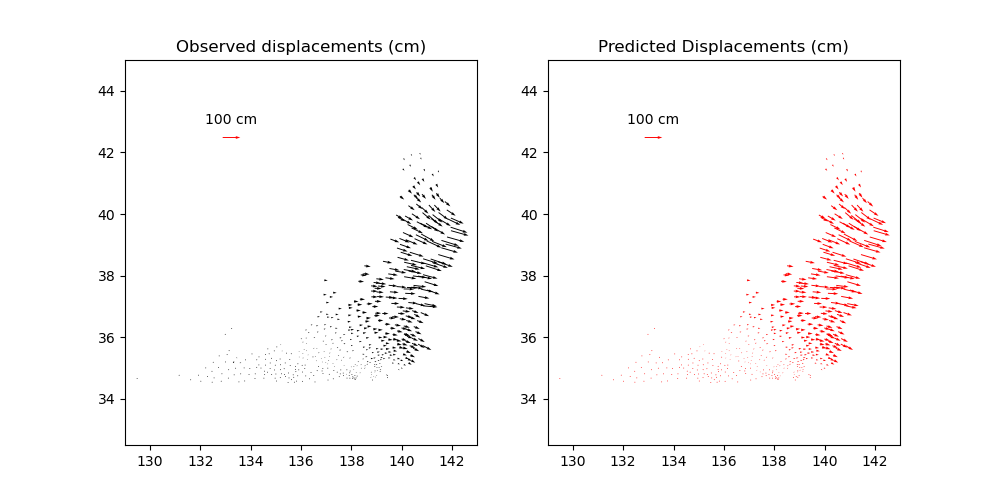

In [39]:
# calculate displacements by which components

# square the components
east_disp = np.square(pred_disp[0::3]).reshape(1,-1)
north_disp = np.square(pred_disp[1::3]).reshape(1, -1)

# add together north and east disp, sum down column, take square root for magnitude of horiz disp
total_disp = np.sqrt(np.sum(np.vstack((east_disp, north_disp)), axis=0))

# calc disp from cmi, beginning from the cmi elements to the end of the cmi elements
cmi_disp = disp_mat[:, all_elem_beg[1]:all_elem_beg[2]].dot(est_slip[all_elem_beg[1]:all_elem_beg[2]]) 
cmi_e = np.square(cmi_disp[0::3]).reshape(1,-1) # square components
cmi_n = np.square(cmi_disp[1::3]).reshape(1,-1)
total_cmi_disp = np.sqrt(np.sum(np.vstack((cmi_e, cmi_n)), axis=0))

# fault disp
fault_disp = disp_mat[:, all_elem_beg[0]:all_elem_beg[1]].dot(est_slip[all_elem_beg[0]:all_elem_beg[1]])
fault_e = np.square(fault_disp[0::3]).reshape(1,-1) # square components
fault_n = np.square(fault_disp[1::3]).reshape(1,-1)
total_fault_disp = np.sqrt(np.sum(np.vstack((fault_e, fault_n)), axis=0))


fig, ax = plt.subplots(1, 2, figsize=(10,5))
Q= ax[0].quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale, color='k', label='observed')
ax[0].quiverkey(Q, X = 0.3, Y=0.8, U=100, label='100 cm',labelpos='N', color='r')
ax[0].set_title("Observed displacements (cm)")
ax[0].set_ylim([32.5, 45])
ax[0].set_xlim([129, 143])

Q1 = ax[1].quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r', label='predicted')
ax[1].quiverkey(Q1, X=0.3, Y=0.8, U=100, label="100 cm", labelpos='N', color='r')
#ax.quiver(gps.lon, gps.lat, data_vector[0:1497:3], data_vector[1:1497:3], scale=vec_scale, color='b')
ax[1].set_ylim([32.5, 45])
ax[1].set_xlim([129, 143])
plt.title("Predicted Displacements (cm)")

if saveFigures and all_disp:
    plt.savefig('totalDisp.png')
    os.system('mv ./totalDisp.png ' + fig_path) # move it into the test output folder


fig, ax = plt.subplots(1, 2, figsize=(10,5))
Q2 = ax[0].quiver(gps.lon, gps.lat, cmi_disp[0::3], cmi_disp[1::3], scale=vec_scale, color='b', label="cmi contribution")
ax[0].quiverkey(Q2, X=0.3, Y=0.8, U=100, label="100 cm", labelpos='N', color='b')
ax[0].set_ylim([32.5, 45])
ax[0].set_xlim([129, 143])
ax[0].set_title("Cmi contribution")

Q3 = ax[1].quiver(gps.lon, gps.lat, fault_disp[0::3], fault_disp[1::3], scale=vec_scale, color='g', label="fault contribution")
ax[1].quiverkey(Q3, X=0.3, Y=0.8, U=100, label="100 cm", labelpos='N', color='g')
ax[1].set_ylim([32.5, 45])
ax[1].set_xlim([129, 143])
plt.title("fault contribution")

if saveFigures and disp_sep:
    plt.savefig('dispByComponent.png')
    os.system('mv ./dispByComponent.png ' + fig_path)


plt.show()

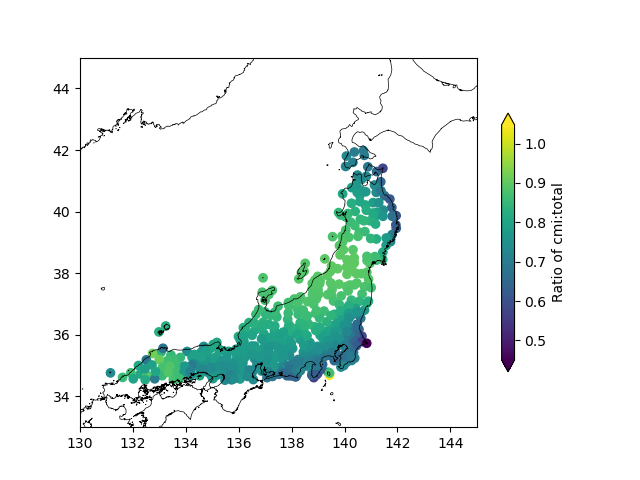

In [38]:
ratio = total_cmi_disp / total_disp

plt.close('all')
fig, ax = plt.subplots()
dots = ax.scatter(gps.lon, gps.lat, c=ratio) # color by ratio of cmi_disp / total disp
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="k", linewidth=0.5)
ax.set_xlim(130, 145)
ax.set_ylim(33, 45)
# Add a customized colorbar
cbar = fig.colorbar(dots, ax=ax, orientation='vertical', shrink=0.7,
                    label='Ratio of cmi:total', extend='both')

if saveFigures and ratio_fig:
    plt.savefig("ratioCmiToTotal.png")
    os.system("mv ./ratioCmiToTotal.png " + fig_path)

plt.show()

#### Residuals

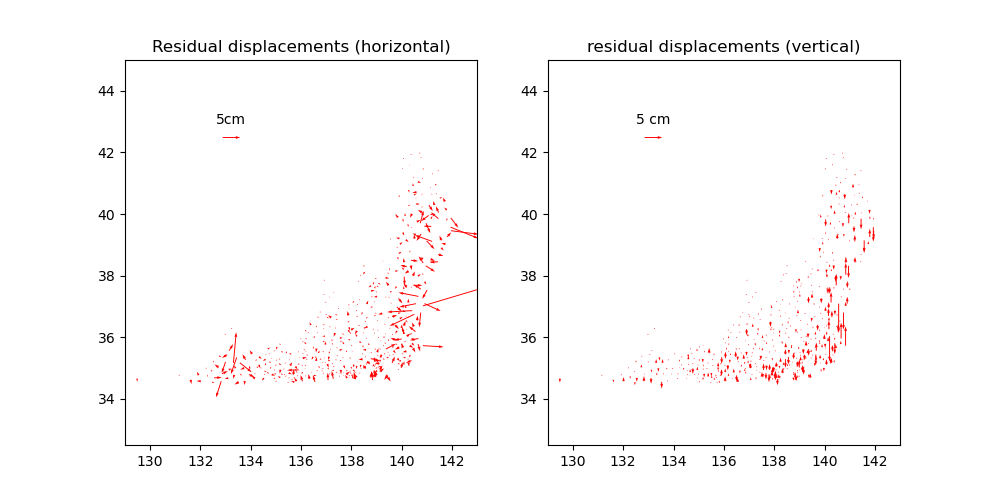

In [31]:
# calculate gps displacement residuals
# residual = actual - predicted

residuals = np.empty((len(gps.lon), 3))
actual = np.hstack((np.array(gps.east_vel).reshape(-1,1), np.array(gps.north_vel).reshape(-1,1), np.array(gps.up_vel).reshape(-1,1)))

# predicted / calculated values
calc_east = pred_disp[0::3].flatten()
calc_north = pred_disp[1::3].flatten()
calc_up = pred_disp[2::3].flatten()

residuals[:,0] = actual[:,0] - calc_east
residuals[:,1] = actual[:,1] - calc_north
residuals[:,2] = actual[:,2] - calc_up

# calc root mean square residuals
resid_sqr = np.square(residuals) # square all residuals
# Calculate the Mean Squared Error (MSE)
mse = np.mean(resid_sqr)
# Calculate the Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)
# print(f"root mean square residual: %.3f cm" % rmse)

#print(np.mean(residuals))

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(10,5))
#ax.quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale, color='k', label='observed')
Q = ax[0].quiver(gps.lon, gps.lat, residuals[:,0], residuals[:,1], scale=vec_scale/20, color='r', label="residuals")
ax[0].quiverkey(Q, X=0.3, Y=0.8, U=5, label="5cm", labelpos='N', color='r')
#ax.quiver(gps.lon, gps.lat, data_vector[0:1497:3], data_vector[1:1497:3], scale=vec_scale, color='b')
ax[0].set_ylim([32.5, 45])
ax[0].set_xlim([129, 143])
ax[0].set_title("Residual displacements (horizontal)")

Q1 = ax[1].quiver(gps.lon, gps.lat, 0, residuals[:,2], scale=vec_scale/20, color='r', label="residuals")
ax[1].quiverkey(Q1, X=0.3, Y=0.8, U=5, label='5 cm', labelpos='N', color='r')
ax[1].set_ylim([32.5, 45])
ax[1].set_xlim([129, 143])
plt.title("residual displacements (vertical)")
#plt.legend()

if saveFigures and resid_fig:
    plt.savefig("residuals.png")
    os.system("mv ./residuals.png " + fig_path)

plt.show()



#### Cross Section

In [32]:
## create a cross section of the mesh

# Create depth contour points using triangle elements spanning the CMI depth

# depth of the CMI
cross_sec_lat = 39.3


# triangle node values and empty list
# each row is a triangle element [lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3]
nodes = np.empty((both["lon1"].size, 9))
nodes[:,0] = both["lon1"] ; nodes[:,1] = both["lat1"] ; nodes[:,2] = both["dep1"]
nodes[:,3] = both["lon2"] ; nodes[:,4] = both["lat2"] ; nodes[:,5] = both["dep2"]
nodes[:,6] = both["lon3"] ; nodes[:,7] = both["lat3"] ; nodes[:,8] = both["dep3"]

sort_by = [] # python implements lists as dynamic arrays.
# for each row (triangle element), check if the depths span the contour needed
# if the depths span the contour, that means the triangle legs cross 60 km depth
# and a point on two legs can be included in the contour 

for i in range(np.size(nodes, 0)):
    node_lat = [nodes[i,1], nodes[i,4], nodes[i,7]] # access the latitude values of a triangle element
    if (max(node_lat) > cross_sec_lat > min(node_lat)):
        sort_by.append(True)
    else:
        sort_by.append(False)

bool_mask = np.array(sort_by) 

# construct an array where each row is a triangle (lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3)
# which spans the cross section, sorted by the boolean mask made earlier
tri_elem = np.empty((bool_mask.sum(), 9)) #sum is adding up True=1 False=0
tri_elem[::] = nodes[::][bool_mask] # grab triangle elements based on the cross section spanning criteria

# there are six combinations of point arrangements, but only 3 unique combinations of line segments ac, ab, bc
# array for points along the depth contour (including duplicates), each element will have two points
cross_all = np.empty(((2*np.size(tri_elem, 0)), 3)) 
m = 0 # row number of the current point, initialized outside of loop

# determine line segments crossing plane, determine point coordinates on the line segment
# add the points to the array
for j in range(np.size(tri_elem, 0)):
    a = tri_elem[j,[0,1,2]] #node a
    b = tri_elem[j,[3,4,5]] #node b
    c = tri_elem[j,[6,7,8]] #node c

    # create direction vectors for line segments
    # all three are created to avoid code clutter in if-statements
    ab = direction_vector(a, b)
    ac = direction_vector(a, c)
    bc = direction_vector(b, c)

    # determine the combination of nodes north and south of the cross section
    combo = [bool(a[1]>cross_sec_lat), bool(b[1]>cross_sec_lat), bool(c[1]>cross_sec_lat)]

    # ab, ac are the triangle legs when a is alone north or south of the line
    if ((combo==[True, False, False]) or (combo==[False,True,True])):
        t1 = scalar2(a, b, cross_sec_lat)
        t2 = scalar2(a, c, cross_sec_lat)

        # each point along the depth contour can be found using an end point, plus a scalar quantity along a direction vector
        p1 = point_grab(ab, t1, a) 
        p2 = point_grab(ac, t2, a)

        cross_all[m,0] = p1[0] ; cross_all[m,1] = p1[1] ; cross_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        cross_all[m,0] = p2[0] ; cross_all[m,1] = p2[1] ; cross_all[m,2] = p2[2]
        m+=1 # increment row

    # ab, bc when b is alone north or south of the line
    elif ((combo==[True,False,True]) or (combo==[False,True,False])):
        t1 = scalar2(a, b, cross_sec_lat)
        t2 = scalar2(b, c, cross_sec_lat)

        p1 = point_grab(ab, t1, a)
        p2 = point_grab(bc, t2, b)

        cross_all[m,0] = p1[0] ; cross_all[m,1] = p1[1] ; cross_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        cross_all[m,0] = p2[0] ; cross_all[m,1] = p2[1] ; cross_all[m,2] = p2[2]
        m+=1 # increment row

    # only remaining line segment combination is [ac, bc], where vertex C is isolated north/south
    else:
        t1 = scalar2(a, c, cross_sec_lat)
        t2 = scalar2(b, c, cross_sec_lat)

        #each of the three components of point1 are endpoint, plus a scalar quantity of the direction vector
        p1 = point_grab(ac, t1, a)
        p2 = point_grab(bc, t2, b) # the z component will always be 60 km or plane_depth, including the equation helps clarify other indicies

        cross_all[m,0] = p1[0] ; cross_all[m,1] = p1[1] ; cross_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        cross_all[m,0] = p2[0] ; cross_all[m,1] = p2[1] ; cross_all[m,2] = p2[2]
        m+=1 # increment row


# triangles share legs, so points are repeated unnecessarily, this takes only the unique rows in the 2D array


# # using pandas not numpy, because numpy will sort the columns, but that shuffles lon, lat pairs apart
if 0:
    plt.close('all')
    fig, ax = plt.subplots()
    plt.scatter(cross_all[:,0], cross_all[:,2])
    plt.show()

In [33]:
from rich.progress import track 
import warnings
import cutde.halfspace as cutde_halfspace

def get_tde_to_velocities_single_mesh(meshes, station, config, mesh_idx):
    """Calculates the elastic displacement partial derivatives based on the
    T. Ben Thompson cutde of the Nikhool and Walters (2015) equations
    for the displacements resulting from slip on a triangular
    dislocation in a homogeneous elastic half space.

    The linear operator is structured as ():

                ss(tri1)  ds(tri1) ts(tri1) ... ss(triN) ds(triN) ts(triN)
    ve(station 1)
    vn(station 1)
    vu(station 1)
    .
    .
    .
    ve(station N)
    vn(station N)
    vu(station N)

    """
    if len(meshes) > 0:
        n_tris = meshes[mesh_idx].lon1.size
        if not station.empty:
            tri_operator = np.zeros((3 * len(station), 3 * n_tris))

            # Loop through each segment and calculate displacements for each slip component
            for i in track(range(n_tris), description="Meshed surface elastic     "):
                (
                    vel_east_strike_slip,
                    vel_north_strike_slip,
                    vel_up_strike_slip,
                ) = get_tri_displacements_single_mesh(
                    station.lon.to_numpy(),
                    station.lat.to_numpy(),
                    station.dep,
                    meshes,
                    config.material_lambda,
                    config.material_mu,
                    tri_idx=i,
                    strike_slip=1,
                    dip_slip=0,
                    tensile_slip=0,
                    mesh_idx=mesh_idx,
                )
                (
                    vel_east_dip_slip,
                    vel_north_dip_slip,
                    vel_up_dip_slip,
                ) = get_tri_displacements_single_mesh(
                    station.lon.to_numpy(),
                    station.lat.to_numpy(),
                    station.dep,
                    meshes,
                    config.material_lambda,
                    config.material_mu,
                    tri_idx=i,
                    strike_slip=0,
                    dip_slip=1,
                    tensile_slip=0,
                    mesh_idx=mesh_idx,
                )
                (
                    vel_east_tensile_slip,
                    vel_north_tensile_slip,
                    vel_up_tensile_slip,
                ) = get_tri_displacements_single_mesh(
                    station.lon.to_numpy(),
                    station.lat.to_numpy(),
                    station.dep,
                    meshes,
                    config.material_lambda,
                    config.material_mu,
                    tri_idx=i,
                    strike_slip=0,
                    dip_slip=0,
                    tensile_slip=1,
                    mesh_idx=mesh_idx,
                )
                tri_operator[0::3, 3 * i] = np.squeeze(vel_east_strike_slip)
                tri_operator[1::3, 3 * i] = np.squeeze(vel_north_strike_slip)
                tri_operator[2::3, 3 * i] = np.squeeze(vel_up_strike_slip)
                tri_operator[0::3, 3 * i + 1] = np.squeeze(vel_east_dip_slip)
                tri_operator[1::3, 3 * i + 1] = np.squeeze(vel_north_dip_slip)
                tri_operator[2::3, 3 * i + 1] = np.squeeze(vel_up_dip_slip)
                tri_operator[0::3, 3 * i + 2] = np.squeeze(vel_east_tensile_slip)
                tri_operator[1::3, 3 * i + 2] = np.squeeze(vel_north_tensile_slip)
                tri_operator[2::3, 3 * i + 2] = np.squeeze(vel_up_tensile_slip)
        else:
            tri_operator = np.empty(0)
    else:
        tri_operator = np.empty(0)
    return tri_operator

def get_tri_displacements_single_mesh(
    obs_lon,
    obs_lat,
    obs_depth, # added
    meshes,
    material_lambda,
    material_mu,
    tri_idx,
    strike_slip,
    dip_slip,
    tensile_slip,
    mesh_idx,
):
    """Calculate surface displacments due to slip on a triangular dislocation
    element in a half space.  Includes projection from longitude and
    latitude to locally tangent planar coordinate system.
    """
    poissons_ratio = material_mu / (2 * (material_mu + material_lambda))

    # Project coordinates
    tri_centroid_lon = meshes[mesh_idx].centroids[tri_idx, 0]
    tri_centroid_lat = meshes[mesh_idx].centroids[tri_idx, 1]
    projection = celeri.celeri_util.get_transverse_projection(tri_centroid_lon, tri_centroid_lat)
    obs_x, obs_y = projection(obs_lon, obs_lat)
    tri_x1, tri_y1 = projection(
        meshes[mesh_idx].lon1[tri_idx], meshes[mesh_idx].lat1[tri_idx]
    )
    tri_x2, tri_y2 = projection(
        meshes[mesh_idx].lon2[tri_idx], meshes[mesh_idx].lat2[tri_idx]
    )
    tri_x3, tri_y3 = projection(
        meshes[mesh_idx].lon3[tri_idx], meshes[mesh_idx].lat3[tri_idx]
    )
    tri_z1 = KM2M * meshes[mesh_idx].dep1[tri_idx]
    tri_z2 = KM2M * meshes[mesh_idx].dep2[tri_idx]
    tri_z3 = KM2M * meshes[mesh_idx].dep3[tri_idx]

    # Package coordinates for cutde call
    obs_coords = np.vstack((obs_x, obs_y, KM2M * obs_depth)).T # changed from celeri, multiply by KM2M so that its in m
    tri_coords = np.array(
        [[tri_x1, tri_y1, tri_z1], [tri_x2, tri_y2, tri_z2], [tri_x3, tri_y3, tri_z3]]
    )

    # Call cutde, multiply by displacements, and package for the return
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        disp_mat = cutde_halfspace.disp_matrix(
            obs_pts=obs_coords, tris=np.array([tri_coords]), nu=poissons_ratio
        )
    slip = np.array([[strike_slip, dip_slip, tensile_slip]])
    disp = disp_mat.reshape((-1, 3)).dot(slip.flatten())
    vel_east = disp[0::3]
    vel_north = disp[1::3]
    vel_up = disp[2::3]
    return vel_east, vel_north, vel_up


In [34]:
# create a net of points to work as stations and calculate their partials

max_z = cmi_depth * 1.5
cross_lat = cross_sec_lat
lon_lim = [min_lon, 144] # min lon from cmi meshing
num_deps = int(max_z/10) + 1
num_lons = 50

# create a grid of points
nx, ny = (num_lons, num_deps)
x = np.linspace(min_lon, 144, nx)
y = np.linspace(0, -1*max_z, num_deps)
xv, yv = np.meshgrid(x, y)

# latitudes are needed because celeri looks for three cols (lon, lat, dep)
cross_lats = np.full_like(xv, cross_lat)
cross_points = np.hstack((xv.reshape(-1,1), cross_lats.reshape(-1,1), yv.reshape(-1,1)))

# it wants a dataframe too
cross_stations = pd.DataFrame(cross_points, columns=['lon', 'lat', 'dep'])

# Allocate space for slip-to-displacement array
cross_disp_mat = np.zeros((3*len(cross_stations.lon), 3*np.sum(n_tri)))


for mesh_idx in range(len(meshes)):
    # Calculate slip to displacement partials, using geographic coordinates
    cross_disp_mat[:, 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = get_tde_to_velocities_single_mesh(meshes, cross_stations, config, mesh_idx)


# take out the tensile columns of the subduction zone matrix, leave the CMI matrix as is (throw calculated in sep code block)
cross_disp_mat = np.delete(cross_disp_mat, throw, axis=1)



Output()

Output()

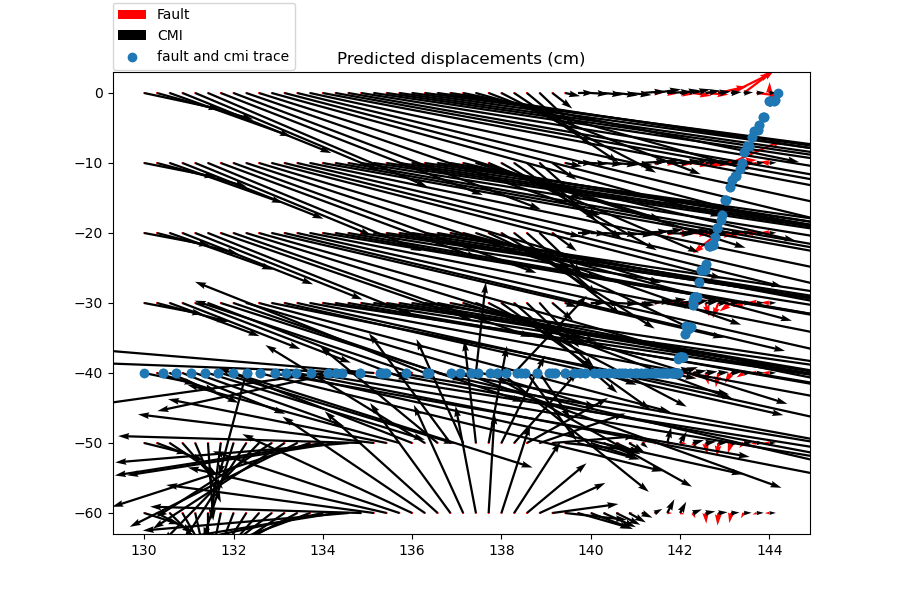

In [35]:
# multiply the partials of the points by the est_slip

plt.close('all')
cross_disp_fault = cross_disp_mat[:, all_elem_beg[0]:all_elem_beg[1]].dot(est_slip[all_elem_beg[0]:all_elem_beg[1]]) 
cross_disp_cmi = cross_disp_mat[:, all_elem_beg[1]:all_elem_beg[2]].dot(est_slip[all_elem_beg[1]:all_elem_beg[2]]) 


fig, ax = plt.subplots(figsize=(9,6))

ax.quiver(cross_stations.lon, cross_stations.dep, cross_disp_fault[0::3], cross_disp_fault[2::3], scale=vec_scale, color='r', label='Fault')
ax.quiver(cross_stations.lon, cross_stations.dep, cross_disp_cmi[0::3], cross_disp_cmi[2::3], scale=vec_scale, color='k', label='CMI')
# Q = ax[0].quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r', label='predicted')
# ax.quiverkey(Q, X = 0.3, Y=0.8, U=100, label='100 cm',labelpos='N', color='r')
ax.set_title("Predicted displacements (cm)")

plt.scatter(cross_all[:,0], cross_all[:,2], label="fault and cmi trace")

plt.legend(bbox_to_anchor=(0, 1.15), loc='upper left', borderaxespad=0.)

if saveFigures and cross_fig:
    plt.savefig('crossSection.png')
    os.system('mv ./crossSection.png ' + fig_path)

plt.show()

# pred_disp = disp_mat[:, 1+all_elem_beg[1]::3].dot(est_slip[1+all_elem_beg[1]::3])

# how do I separate out the components from the cmi and the fault? 
# fault_disp = cross_disp_mat[:all_elem_beg[0], all_elem_beg[1]].dot(est_slip[])



### Numerical output processing 

In [ ]:
# calculate the moment for slip on fault vs slip on cmi
# moment = rigidity x area x slip

rigidity = 3e10 #N / m^2 (is this the same though for the CMI at depth?)

# calc slip mag
fault_d_slip = np.square(est_slip[1:end_idx:2]) # one for dip slip
fault_s_slip = np.square(est_slip[0:end_idx:2]) # zero for strike slip
fault_slip = np.sqrt(np.sum(np.vstack((fault_d_slip, fault_s_slip))))

fault_moment = rigidity * (fault["area"]) * fault_slip
fault_total_moment = np.sum(fault_moment) # in N / m^2

horiz_d_slip = np.square(est_slip[1+end_idx::3])
horiz_s_slip = np.square(est_slip[0+end_idx::3])
horiz_slip = np.sqrt(np.sum(np.vstack((horiz_d_slip, horiz_s_slip))))

horiz_moment = rigidity * (horiz["area"]) * horiz_slip
horiz_total_moment = np.sum(horiz_moment)


print("Maximum magnitude of fault slip (m): ", max_mag_f)
print("Maximum magnitude of slip on cmi (m): ", max_mag_h)
# calc done in slip distribution plotting

print("Fault moment: ", fault_total_moment)
print("Horiz moment: ", horiz_total_moment)

print(f"root mean square residual: %.3f cm" % rmse)
# calc done in residual plotting


if saveData:
    results = ["Maximum magnitude of fault slip (m): " + str(max_mag_f), "Maximum magnitude of slip on cmi (m): " + str(max_mag_h), 
               "Fault moment: " + str(fault_total_moment), "CMI moment: " + str(horiz_total_moment), "root mean square residual (cm): " + str(rmse)]
    with open("numericalResults.txt", "w") as file:
        for item in results:
            file.write("\n")
            file.write(item + "\n")
    
    os.system('mv ./numericalResults.txt ' + fig_path)


Maximum magnitude of fault slip (m):  3.7679924608873794
Maximum magnitude of slip on cmi (m):  3.8730948535922014
Fault moment:  3.872698628146741e+25
Horiz moment:  9.732117070002377e+26
root mean square residual: 1.208 cm
